### Install sklearn for Windows devices

In [ ]:
!pip install -U scikit-learn
!pip install nltk
!pip install matplotlib

### Install sklearn for MacOS

In [ ]:
!pip3 install -U scikit-learn
!pip3 install nltk
!pip3 install matplotlib

## Load Data

In [14]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv('trg.csv')
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(data.abstract)

data = data.rename(columns={'class': 'class_label'})
X = data.drop('class_label', axis=1)
y = data['class_label']
data  = pd.DataFrame(data= matrix.toarray(), columns = vectorizer.get_feature_names_out())
data.head()

,00,000,0001,00017,0003,0004,0005,001,0021,003,...,zwf1,zwitterionic,zygomycete,zygomycetes,zygotic,zymogen,zymogens,zymogram,zymography,zymomonas
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Standard Naive Bayes Model

In [15]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X['abstract'], y, test_size=0.1, random_state=42)

class NaiveBayes:
    def __init__(self):
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.class_counts = defaultdict(int)
        self.vocab = set()
        self.class_priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.vocab = set()
        for cls in self.classes:
            self.class_counts[cls] = sum(1 for label in y if label == cls)
        for abstract, label in zip(X, y):
            for word in set(abstract.split()):
                self.word_counts[label][word] += 1
                self.vocab.add(word)
        self.vocab_size = len(self.vocab)
        total_docs = len(X)
        self.class_priors = {cls: self.class_counts[cls] / total_docs for cls in self.classes}

    def predict(self, documents):
        predictions = []
        for document in documents:
            posterior_probs = {cls: np.log(self.class_priors[cls]) for cls in self.classes}
            document_words = document.split()
            word_counts = {word: document_words.count(word) for word in set(document_words)}
            for word, count in word_counts.items():
                for cls in self.classes:
                    word_count_in_class = self.word_counts[cls].get(word, 0)
                    total_words_in_class = sum(self.word_counts[cls].values())
                    conditional_prob = (word_count_in_class + 1) / (total_words_in_class + self.vocab_size)
                    posterior_probs[cls] += count * np.log(conditional_prob)
            predicted_class = max(posterior_probs, key=posterior_probs.get)
            predictions.append(predicted_class)
        return predictions
    
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

nb_clf = NaiveBayes()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

for train_index, test_index in kf.split(X['abstract']):
    X_train, X_test = X['abstract'][train_index], X['abstract'][test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print("5-fold cross-validation list of accuracies:",accuracies)
print(f"5-fold cross-validation mean accuracy: {np.mean(accuracies):.2f}")


Accuracy: 0.93
5-fold cross-validation list of accuracies: [0.96, 0.9875, 0.9875, 0.99375, 0.99625]
5-fold cross-validation mean accuracy: 0.98


# Improved Naive Bayes model with extra-preprocessing (stopwords, use of n-grams, stemming)

In [18]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer

X_train, X_test, y_train, y_test = train_test_split(X['abstract'], y, test_size=0.01, random_state=42)

class NaiveBayes:
    def __init__(self, alpha=1.0, stemming=False):
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.class_counts = defaultdict(int)
        self.vocab = set()
        self.class_priors = {}
        self.alpha = alpha
        self.stemming = stemming
        if self.stemming:
            self.stemmer = PorterStemmer()
            
            
    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            "stemming": self.stemming,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def preprocess(self, text):
        words = text.split()
        processed_words = []
        skip_next = False
        skip_next_next = False

        for i, word in enumerate(words):
            if skip_next:
                skip_next = False
                if skip_next_next:
                    skip_next = True
                    skip_next_next = False
                continue

            if word == "homo" and i + 1 < len(words) and words[i + 1] == "sapiens":
                processed_words.append("homo-sapiens")
                skip_next = True
                continue

            if word == "escherichia" and i + 1 < len(words) and words[i + 1] == "coli":
                processed_words.append("escherichia-coli")
                skip_next = True
                continue

            if word == "human" and i + 2 < len(words) and words[i + 1] == "immunodeficiency" and words[i + 2] == "virus":
                processed_words.append("human-immunodeficiency-virus")
                skip_next = True
                skip_next_next = True
                continue

            if self.stemming:
                word = self.stemmer.stem(word)

            if word not in ENGLISH_STOP_WORDS:
                processed_words.append(word)

        return " ".join(processed_words)

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.vocab = set()

        for cls in self.classes:
            self.class_counts[cls] = sum(1 for label in y if label == cls)

        for abstract, label in zip(X, y):
            abstract = self.preprocess(abstract)
            for word in set(abstract.split()):
                self.word_counts[label][word] += 1
                self.vocab.add(word)

        self.vocab_size = len(self.vocab)
        total_docs = len(X)
        self.class_priors = {cls: self.class_counts[cls] / total_docs for cls in self.classes}

    def predict(self, documents):
        predictions = []
        for document in documents:
            document = self.preprocess(document)
            posterior_probs = {cls: np.log(self.class_priors[cls]) for cls in self.classes}
            document_words = document.split()
            word_counts = {word: document_words.count(word) for word in set(document_words)}

            for word, count in word_counts.items():
                for cls in self.classes:
                    word_count_in_class = self.word_counts[cls].get(word, 0)
                    total_words_in_class = sum(self.word_counts[cls].values())
                    conditional_prob = (word_count_in_class + self.alpha) / (total_words_in_class + self.alpha * self.vocab_size)
                    posterior_probs[cls] += count * np.log(conditional_prob)

            predicted_class = max(posterior_probs, key=posterior_probs.get)
            predictions.append(predicted_class)

        return predictions

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

nb_clf = NaiveBayes(alpha=0.5, stemming=True)
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

for train_index, test_index in kf.split(X['abstract']):
    X_train, X_test = X['abstract'][train_index], X['abstract'][test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print("5-fold cross-validation list of accuracies:",accuracies)
print(f"5-fold cross-validation mean accuracy: {np.mean(accuracies):.2f}")

Accuracy: 0.97
5-fold cross-validation list of accuracies: [0.985, 0.99625, 0.99625, 0.99375, 0.9975]
5-fold cross-validation mean accuracy: 0.99


#### Export to tst.csv predictions for kaggle

In [12]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer

class NaiveBayes:
    def __init__(self, alpha=1.0, stemming=False):
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.class_counts = defaultdict(int)
        self.vocab = set()
        self.class_priors = {}
        self.alpha = alpha
        self.stemming = stemming
        if self.stemming:
            self.stemmer = PorterStemmer()
            
            
    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            "stemming": self.stemming,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def preprocess(self, text):
        words = text.split()
        processed_words = []
        skip_next = False
        skip_next_next = False

        for i, word in enumerate(words):
            if skip_next:
                skip_next = False
                if skip_next_next:
                    skip_next = True
                    skip_next_next = False
                continue

            if word == "homo" and i + 1 < len(words) and words[i + 1] == "sapiens":
                processed_words.append("homo-sapiens")
                skip_next = True
                continue

            if word == "escherichia" and i + 1 < len(words) and words[i + 1] == "coli":
                processed_words.append("escherichia-coli")
                skip_next = True
                continue

            if word == "human" and i + 2 < len(words) and words[i + 1] == "immunodeficiency" and words[i + 2] == "virus":
                processed_words.append("human-immunodeficiency-virus")
                skip_next = True
                skip_next_next = True
                continue

            if self.stemming:
                word = self.stemmer.stem(word)

            if word not in ENGLISH_STOP_WORDS:
                processed_words.append(word)

        return " ".join(processed_words)

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.vocab = set()

        for cls in self.classes:
            self.class_counts[cls] = sum(1 for label in y if label == cls)

        for abstract, label in zip(X, y):
            abstract = self.preprocess(abstract)
            for word in set(abstract.split()):
                self.word_counts[label][word] += 1
                self.vocab.add(word)

        self.vocab_size = len(self.vocab)
        total_docs = len(X)
        self.class_priors = {cls: self.class_counts[cls] / total_docs for cls in self.classes}

    def predict(self, documents):
        predictions = []
        for document in documents:
            document = self.preprocess(document)
            posterior_probs = {cls: np.log(self.class_priors[cls]) for cls in self.classes}
            document_words = document.split()
            word_counts = {word: document_words.count(word) for word in set(document_words)}

            for word, count in word_counts.items():
                for cls in self.classes:
                    word_count_in_class = self.word_counts[cls].get(word, 0)
                    total_words_in_class = sum(self.word_counts[cls].values())
                    conditional_prob = (word_count_in_class + self.alpha) / (total_words_in_class + self.alpha * self.vocab_size)
                    posterior_probs[cls] += count * np.log(conditional_prob)

            predicted_class = max(posterior_probs, key=posterior_probs.get)
            predictions.append(predicted_class)

        return predictions


nb_clf = NaiveBayes(alpha=0.5, stemming=True)
nb_clf.fit(X_train, y_train)

data = pd.read_csv('tst.csv')

vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(data.abstract)
X = data.drop('id', axis=1)

y_pred = nb_clf.predict(X['abstract'])

df_predictions = pd.DataFrame({'id': range(1, len(y_pred) + 1), 'class': y_pred})
df_predictions.to_csv('predictions.csv', index=False)

# Report Section

a. Explain and motivate the chosen representation & data preprocessing.


- Representation\
The text data is represented as a bag-of-words, where each document is treated as an unordered collection of words. This allows the Naive Bayes classifier to capture the number of words in each document which can be informative for classification, while ignoring the word order and grammar. This representation is simple, efficient, and has been widely used in text classification tasks.

- Data Preprocessing
1. Tokenization:\
The preprocess function splits the text into individual words, which are the basic units for the bag-of-words representation.
2. Stop Word Removal:\
Common English stop words (e.g., "the", "a", "is") are removed using the ENGLISH_STOP_WORDS set from the sklearn.feature_extraction.text module. Stop words typically have little effect for classification tasks and can be removed. This helps reduce the feature space and computational complexity, while potentially improving the classifier's performance by focusing on more relevant words.
3. Stemming:\
The code provides an option to apply stemming using the PorterStemmer from the nltk.stem module. Stemming reduces words to their base or root form (e.g., "running" and "ran" become "run"). This can help in handling different word forms and potentially improve the classifier's performance by grouping related words together. However, it can also introduce some noise or ambiguity, so it's provided as an optional step.
4. Handling Specific Phrases:\
The preprocess function includes special handling for certain phrases, such as "homo sapiens", "escherichia coli", and "human immunodeficiency virus". Treating certain phrases as single tokens can help preserve their meaning and avoid splitting them into separate words, which could potentially lead to a loss of context or meaning.

b. Explain the idea behind the model improvements and their implementation (including the implementation of the standard Naive Bayes).

##### Standard Naive Bayes implementation:
1. The NaiveBayes class implements the Naive Bayes algorithm for text classification.
2. The fit method learns the class priors and word counts from the training data.
3. The predict method calculates the posterior probabilities for each class and assigns the class with the highest probability.

##### Improvements
1. Text preprocessing - The preprocess method is responsible for preprocessing the text data where it removes English stop words from the text. It also handles certain scientific terms like "homo sapiens", "escherichia coli", and "human immunodeficiency virus" as single tokens.
2. Stemming - The stemming parameter in the NaiveBayes class allows enabling or disabling stemming. If stemming is enabled, the preprocess method uses the PorterStemmer from NLTK to stem the words before adding them to the vocabulary. The PorterStemmer is an algorithm that applies a set of rules to remove common morphological endings from words, effectively reducing them to their stem or root form. For example, the words "running" and "ran",  would all be reduced to the stem "run".
3. Laplace smoothing - The alpha parameter in the NaiveBayes class controls the Laplace smoothing for the word probabilities. In the predict method, the conditional probabilities of words given a class are calculated using the formula: (word_count_in_class + alpha) / (total_words_in_class + alpha * vocab_size). This smoothing helps handle unseen words during prediction and prevents zero probabilities.

c. Explain the evaluation procedure (e.g., cross-validation or training/validation split).

- The code evaluates the Naive Bayes classifier using two methods: a simple train-test split and 5-fold cross-validation. For the train-test split, the data is randomly partitioned into training (eg: 90%) and test (eg: 10%) sets. The model is trained on the training set and evaluated on the test set, with the accuracy score reported. Cross-validation is a more robust evaluation technique where the data is split into 5 folds. The model is trained on 4 folds and evaluated on the remaining fold, and this process is repeated 5 times, with each fold acting as the test set once. The accuracies from all 5 folds are recorded, and the mean accuracy across folds is reported. Cross-validation helps estimate the model's performance more reliably by utilizing all available data for both training and evaluation, mitigating potential issues with a single train-test split.

d. Include and explain the training/validation results for the standard and improved Naive Bayes model. You can summarize results using tables (or plots), but all results have to be explained descriptively as well. be written in plain English and should not be longer than two A4 pages (export the notebook as pdf to see if the report section fits in two pages).

#### Standard Naive Bayes model
- Accuracy: 0.90 - trained on 99% of the dataset\
5-fold cross-validation list of accuracies: [0.96875, 0.98625, 0.9875, 0.99375, 0.99625]\
5-fold cross-validation mean accuracy: 0.99

- Accuracy: 0.93 - trained on 90% of the dataset\
5-fold cross-validation list of accuracies: [0.96, 0.9875, 0.9875, 0.99375, 0.99625]\
5-fold cross-validation mean accuracy: 0.98

#### Improved Naive Bayes model
- Accuracy: 0.97 - trained on 99% of the dataset\
5-fold cross-validation list of accuracies: [0.985, 0.99625, 0.99625, 0.99375, 0.9975]\
5-fold cross-validation mean accuracy: 0.99

- Accuracy: 0.95 - trained on 90% of the dataset\
5-fold cross-validation list of accuracies: [0.965, 0.99625, 0.99625, 0.995, 0.9975]\
5-fold cross-validation mean accuracy: 0.99

From these results, we can observe that the improved Naive Bayes model with preprocessing and stemming generally outperforms the standard Naive Bayes model in terms of accuracy on both the train-test split and cross-validation evaluations. The improvements are more pronounced when evaluating on a smaller test set (1% or 10%), suggesting that the preprocessing and stemming techniques help the model better generalize to unseen data. However, it's worth noting that the differences in accuracy between the models are relatively small, but the improved model consistently performs better across all evaluation scenarios (especially for the Standard Naive Bayes Model which has a smaller test set and lower accuracy).

##### Display Graphical representation

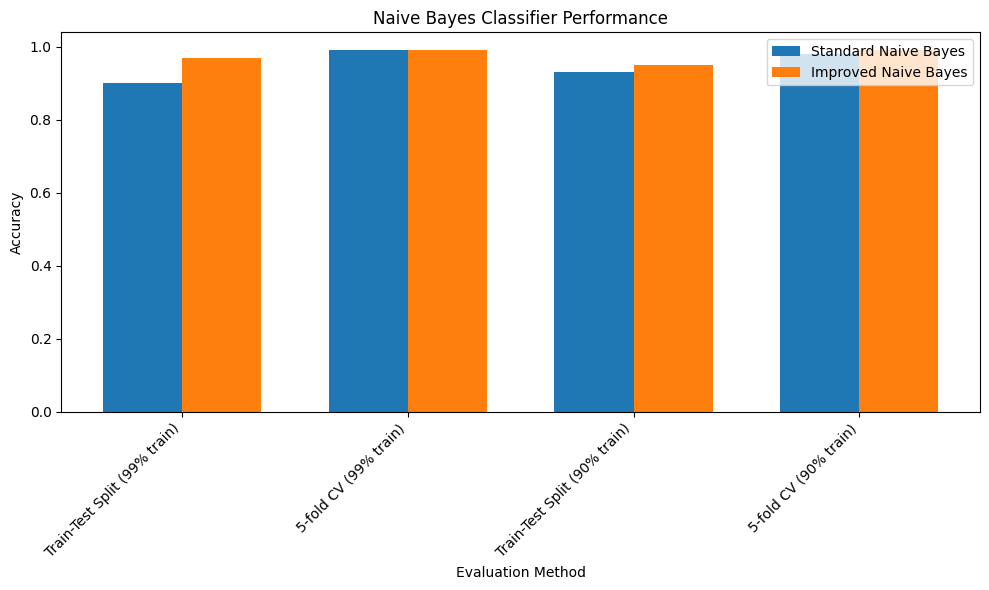

In [10]:
import matplotlib.pyplot as plt

std_nb_accuracies = {
    "Train-Test Split (99% train)": 0.90,
    "5-fold CV (99% train)": 0.99,
    "Train-Test Split (90% train)": 0.93,
    "5-fold CV (90% train)": 0.98
}

imp_nb_accuracies = {
    "Train-Test Split (99% train)": 0.97,
    "5-fold CV (99% train)": 0.99,
    "Train-Test Split (90% train)": 0.95,
    "5-fold CV (90% train)": 0.99
}

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions = np.arange(len(std_nb_accuracies))

ax.bar(bar_positions - bar_width / 2, std_nb_accuracies.values(), bar_width, label="Standard Naive Bayes")

ax.bar(bar_positions + bar_width / 2, imp_nb_accuracies.values(), bar_width, label="Improved Naive Bayes")

ax.set_xticks(bar_positions)
ax.set_xticklabels(std_nb_accuracies.keys())

ax.set_xlabel("Evaluation Method")
ax.set_ylabel("Accuracy")
ax.set_title("Naive Bayes Classifier Performance")

plt.xticks(rotation=45, ha="right")

ax.legend()

plt.tight_layout()
plt.show()